## Goal fo this project 

The primary goal of this project is to develop a vishualization  for forecasting electric power consumption in Tetouan, Morocco.
This will hellp us to proactively address energy demand fluctuations, particularly during extreme weather conditions, and contribute to the efficient allocation of electrical resources.

## 1. Loading the library & dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./Power_coms.csv')
df.head(10)

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  2017-01-01 00:00:00        6.559      73.8      0.083                0.051   
1  2017-01-01 00:10:00        6.414      74.5      0.083                0.070   
2  2017-01-01 00:20:00        6.313      74.5      0.080                0.062   
3  2017-01-01 00:30:00        6.121      75.0      0.083                0.091   
4  2017-01-01 00:40:00        5.921      75.7      0.081                0.048   
5  2017-01-01 00:50:00        5.853      76.9      0.081                0.059   
6  2017-01-01 01:00:00        5.641      77.7      0.080                0.048   
7  2017-01-01 01:10:00        5.496      78.2      0.085                0.055   
8  2017-01-01 01:20:00        5.678      78.1      0.081                0.066   
9  2017-01-01 01:30:00        5.491      77.3      0.082                0.062   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   
5         0.108             26624.81013             17416.41337   
6         0.096             25998.98734             16993.31307   
7         0.093             25446.07595             16661.39818   
8         0.141             24777.72152             16227.35562   
9         0.111             24279.49367             15939.20973   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964  
5             18130.12048  
6             17945.06024  
7             17459.27711  
8             17025.54217  
9             16794.21687

## 2. Dataset Exploration
 This dataset is a CSV file with 3 columns of electric power consumption recorded at a frequency of 6 samples per hour (1 sample every 10 minutes). Each of these 3 columns represents a zone of the city of Tétouan, in Morocco.

Features:

Date Time: Time window of ten minutes.
Temperature: Weather Temperature.
Humidity: Weather Humidity.
Wind Speed: Wind Speed.
General Diffuse Flows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
Diffuse Flows

Target:

Zone 1 Power Consumption
Zone 2 Power Consumption
Zone 3 Power Consumption

## 3. Data Cleaning and Preprocessing

In [2]:
# describing the dataset
df.describe()

Temperature      Humidity     WindSpeed  GeneralDiffuseFlows  \
count  52416.000000  52416.000000  52416.000000         52416.000000   
mean      18.810024     68.259518      1.959489           182.696614   
std        5.815476     15.551177      2.348862           264.400960   
min        3.247000     11.340000      0.050000             0.004000   
25%       14.410000     58.310000      0.078000             0.062000   
50%       18.780000     69.860000      0.086000             5.035500   
75%       22.890000     81.400000      4.915000           319.600000   
max       40.010000     94.800000      6.483000          1163.000000   

       DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
count  52416.000000            52416.000000            52416.000000   
mean      75.028022            32344.970564            21042.509082   
std      124.210949             7130.562564             5201.465892   
min        0.011000            13895.696200             8560.081466   
25%        0.122000            26310.668692            16980.766032   
50%        4.456000            32265.920340            20823.168405   
75%      101.000000            37309.018185            24713.717520   
max      936.000000            52204.395120            37408.860760   

       PowerConsumption_Zone3  
count            52416.000000  
mean             17835.406218  
std               6622.165099  
min               5935.174070  
25%              13129.326630  
50%              16415.117470  
75%              21624.100420  
max              47598.326360

In [3]:
# cheacking for null values 
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [4]:
# Cheaking for skewness
numeric_columns = []       # selecting numeric columns
for i in df.describe().columns:
    numeric_columns.append(i)

df[numeric_columns].skew()

Temperature               0.196719
Humidity                 -0.625166
WindSpeed                 0.462423
GeneralDiffuseFlows       1.306973
DiffuseFlows              2.456907
PowerConsumption_Zone1    0.228864
PowerConsumption_Zone2    0.328876
PowerConsumption_Zone3    1.023871
dtype: float64

Chronological Order and Equidistant Timestamps¶
The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [5]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

In [6]:
chronological_order, equidistant_timestamps
# this is already the case in the data

(True, True)

## 4. Adding Extra Features

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df.astype(float)
df = df.set_index('Datetime')
df = create_features(df)
df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter', 'season']].head()

year  month  day  minute  dayofyear  weekofyear  \
Datetime                                                                 
2017-01-01 00:00:00  2017.0    1.0  1.0     0.0        1.0        52.0   
2017-01-01 00:10:00  2017.0    1.0  1.0    10.0        1.0        52.0   
2017-01-01 00:20:00  2017.0    1.0  1.0    20.0        1.0        52.0   
2017-01-01 00:30:00  2017.0    1.0  1.0    30.0        1.0        52.0   
2017-01-01 00:40:00  2017.0    1.0  1.0    40.0        1.0        52.0   

                     quarter  season  
Datetime                              
2017-01-01 00:00:00      1.0     1.0  
2017-01-01 00:10:00      1.0     1.0  
2017-01-01 00:20:00      1.0     1.0  
2017-01-01 00:30:00      1.0     1.0  
2017-01-01 00:40:00      1.0     1.0

In [8]:
df.head(10)

Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                     
2017-01-01 00:00:00        6.559      73.8      0.083                0.051   
2017-01-01 00:10:00        6.414      74.5      0.083                0.070   
2017-01-01 00:20:00        6.313      74.5      0.080                0.062   
2017-01-01 00:30:00        6.121      75.0      0.083                0.091   
2017-01-01 00:40:00        5.921      75.7      0.081                0.048   
2017-01-01 00:50:00        5.853      76.9      0.081                0.059   
2017-01-01 01:00:00        5.641      77.7      0.080                0.048   
2017-01-01 01:10:00        5.496      78.2      0.085                0.055   
2017-01-01 01:20:00        5.678      78.1      0.081                0.066   
2017-01-01 01:30:00        5.491      77.3      0.082                0.062   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 00:00:00         0.119             34055.69620   
2017-01-01 00:10:00         0.085             29814.68354   
2017-01-01 00:20:00         0.100             29128.10127   
2017-01-01 00:30:00         0.096             28228.86076   
2017-01-01 00:40:00         0.085             27335.69620   
2017-01-01 00:50:00         0.108             26624.81013   
2017-01-01 01:00:00         0.096             25998.98734   
2017-01-01 01:10:00         0.093             25446.07595   
2017-01-01 01:20:00         0.141             24777.72152   
2017-01-01 01:30:00         0.111             24279.49367   

                     PowerConsumption_Zone2  PowerConsumption_Zone3  hour  \
Datetime                                                                    
2017-01-01 00:00:00             16128.87538             20240.96386   0.0   
2017-01-01 00:10:00             19375.07599             20131.08434   0.0   
2017-01-01 00:20:00             19006.68693             19668.43373   0.0   
2017-01-01 00:30:00             18361.09422             18899.27711   0.0   
2017-01-01 00:40:00             17872.34043             18442.40964   0.0   
2017-01-01 00:50:00             17416.41337             18130.12048   0.0   
2017-01-01 01:00:00             16993.31307             17945.06024   1.0   
2017-01-01 01:10:00             16661.39818             17459.27711   1.0   
2017-01-01 01:20:00             16227.35562             17025.54217   1.0   
2017-01-01 01:30:00             15939.20973             16794.21687   1.0   

                     minute  dayofweek  quarter  month  day    year  season  \
Datetime                                                                      
2017-01-01 00:00:00     0.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:10:00    10.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:20:00    20.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:30:00    30.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:40:00    40.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:50:00    50.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 01:00:00     0.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 01:10:00    10.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 01:20:00    20.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 01:30:00    30.0        6.0      1.0    1.0  1.0  2017.0     1.0   

                     dayofyear  dayofmonth  weekofyear  
Datetime                                                
2017-01-01 00:00:00        1.0         1.0        52.0  
2017-01-01 00:10:00        1.0         1.0        52.0  
2017-01-01 00:20:00        1.0         1.0        52.0  
2017-01-01 00:30:00        1.0         1.0        52.0  
2017-01-01 00:40:00        1.0         1.0        52.0  
2017-01-01 00:50:00        1.0         1.0        52.0  
2017-01-01 01:00:00  

## 5. Data visualization

c:\Users\kingq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


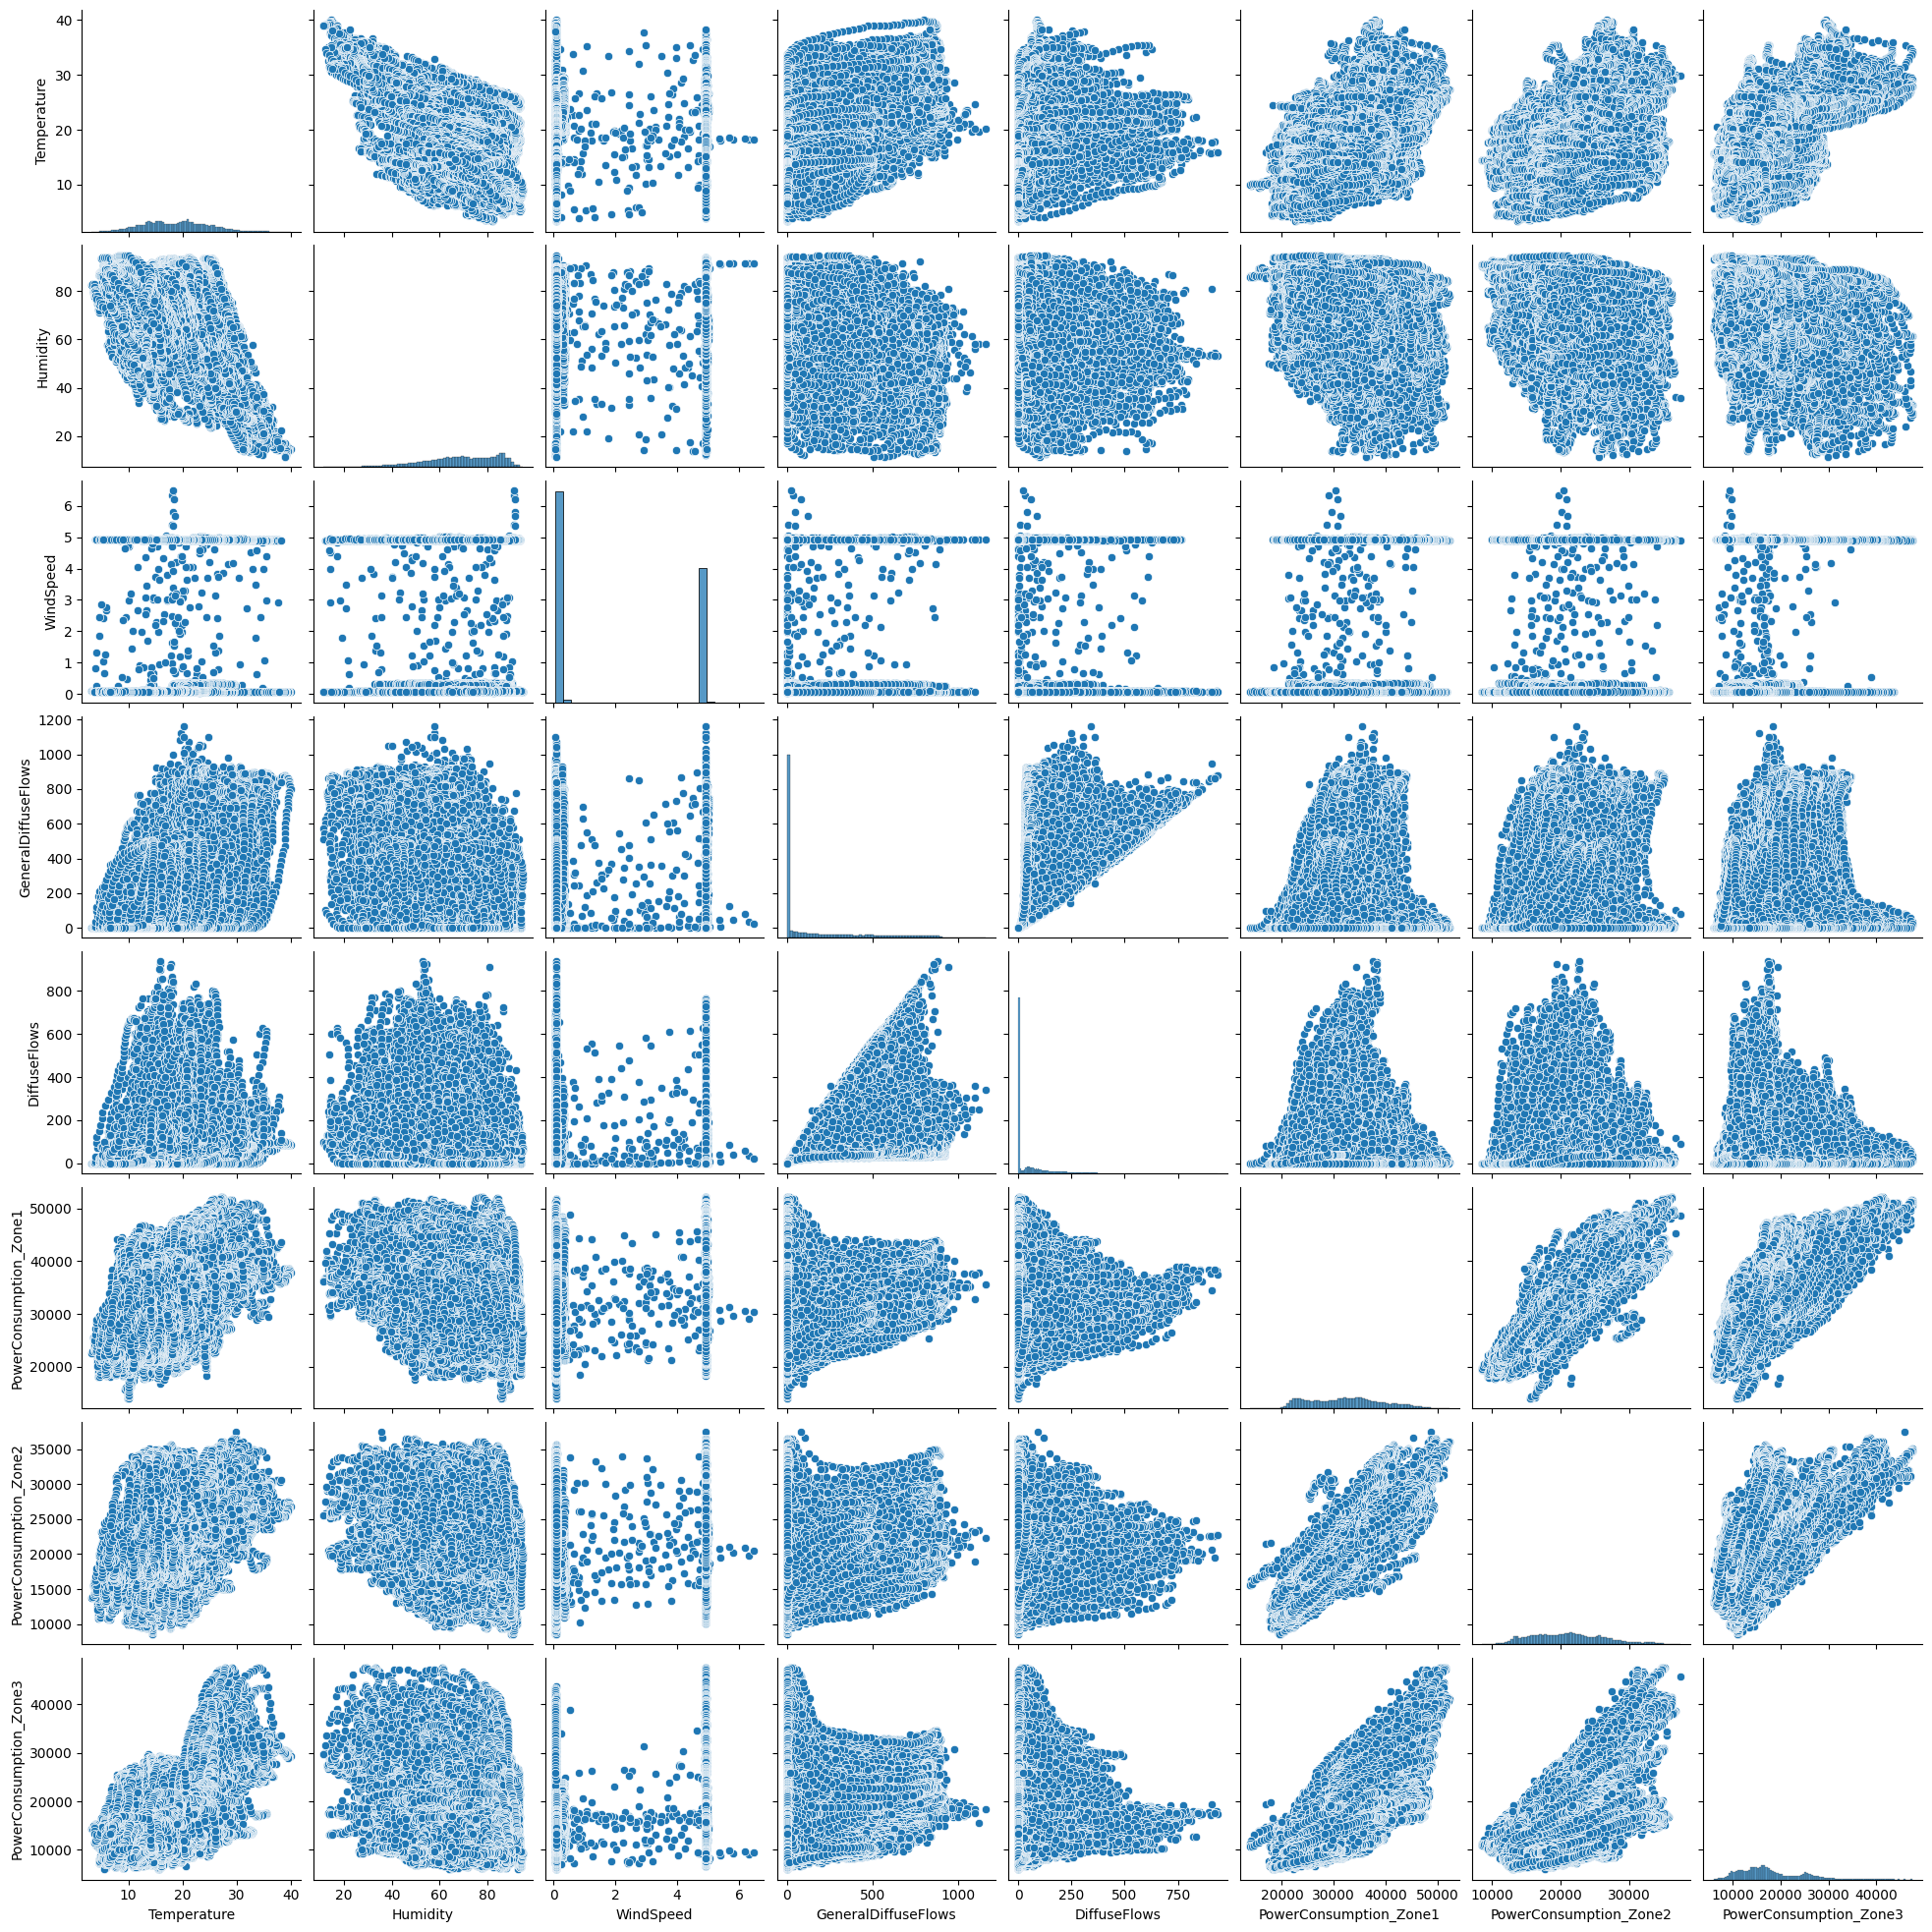

In [9]:
#Data Visualization
# Pairplot to visualize relationships between numerical columns

sns.pairplot(df[numeric_columns])
plt.show()

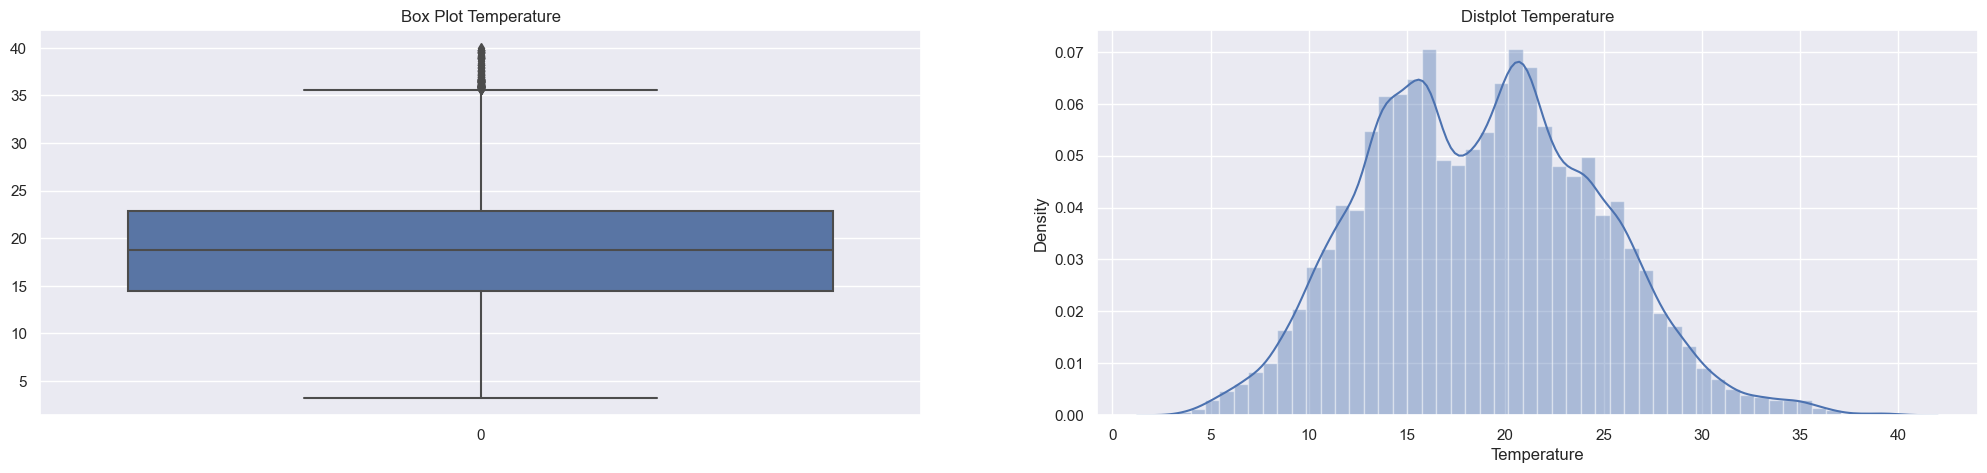

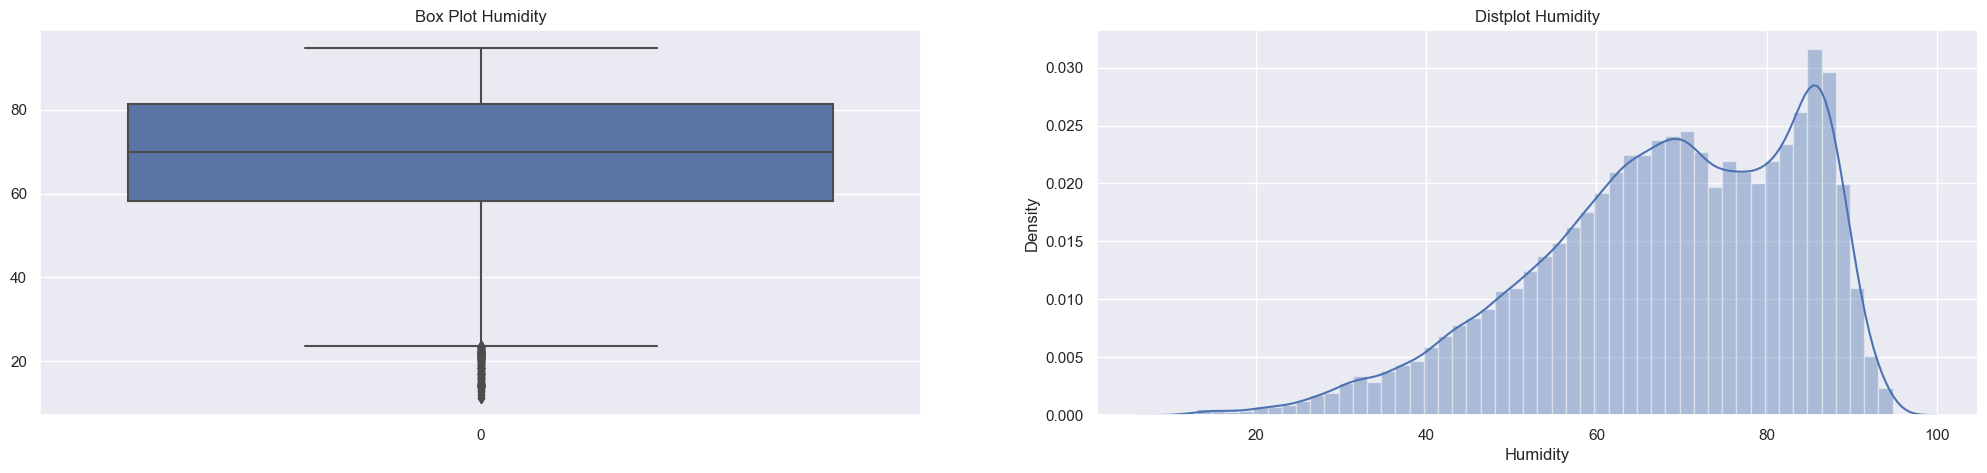

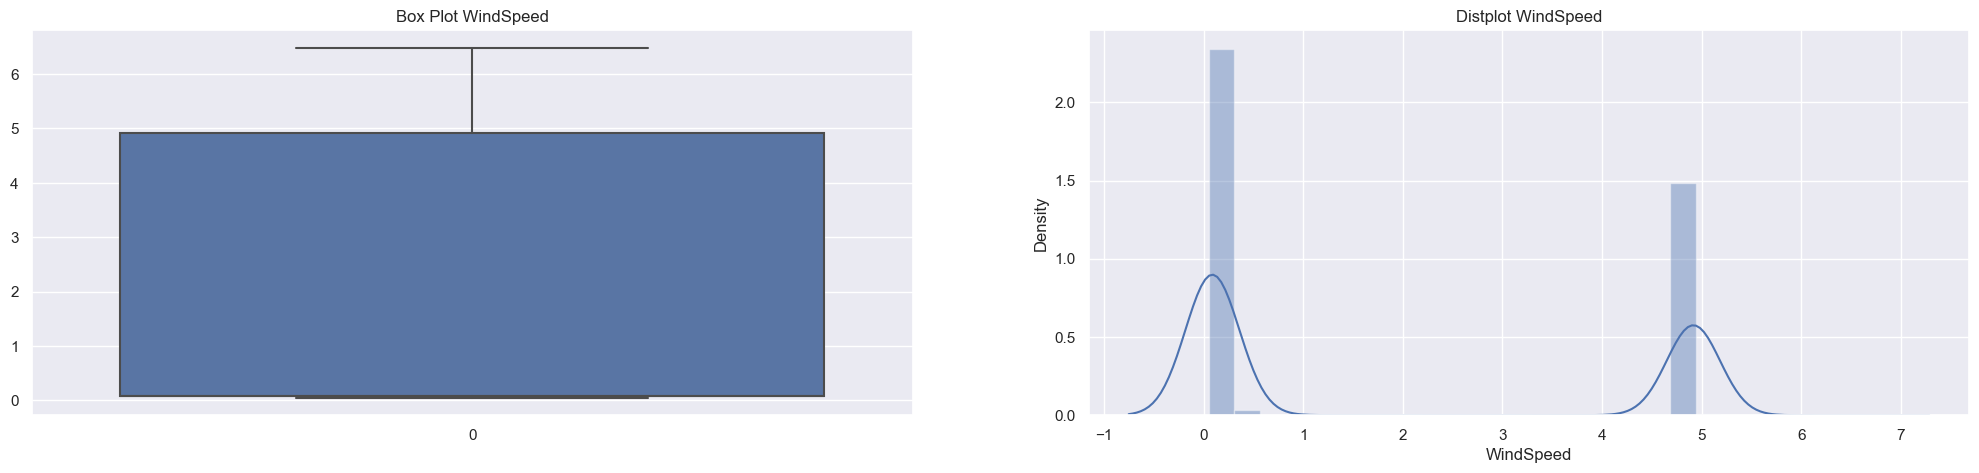

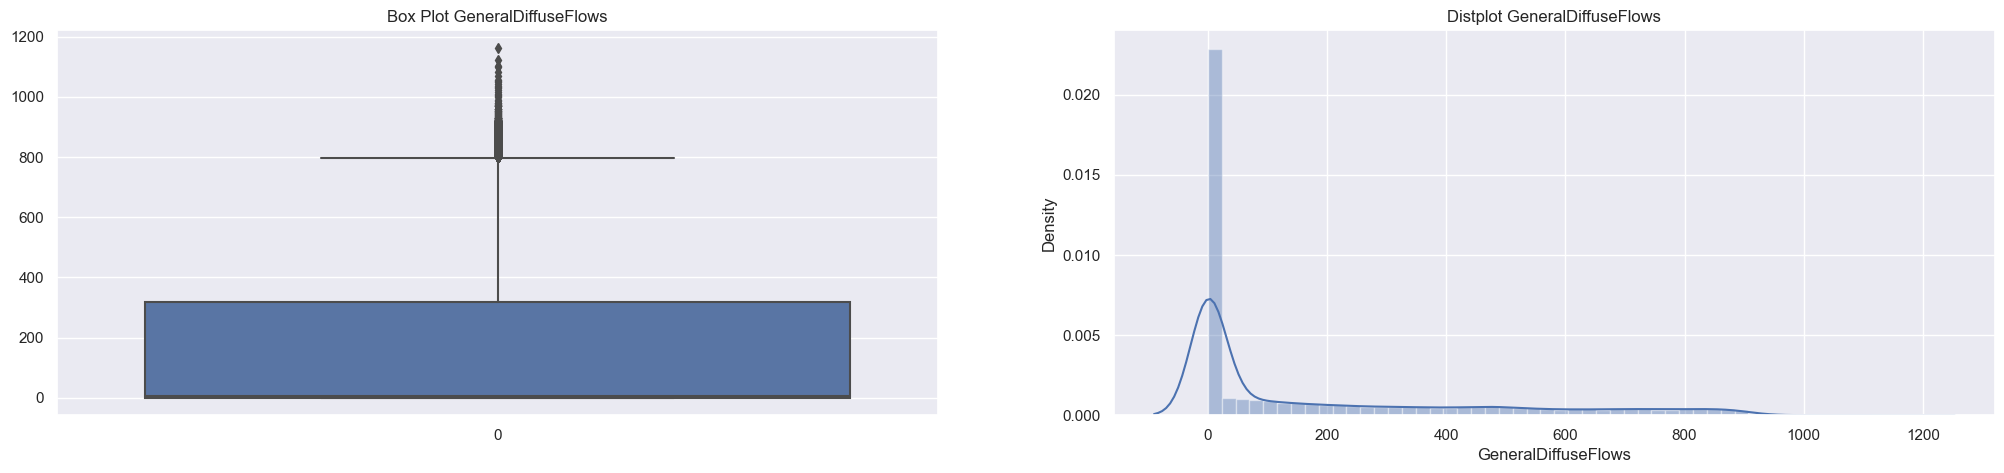

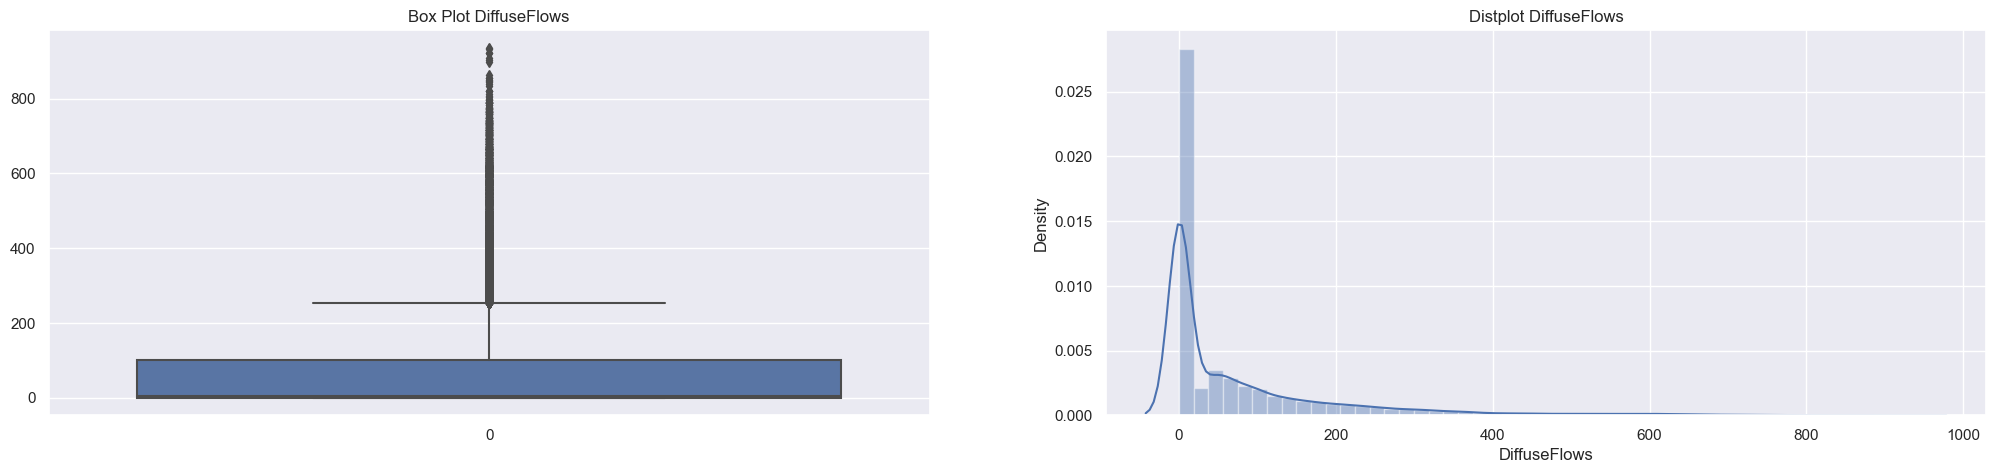

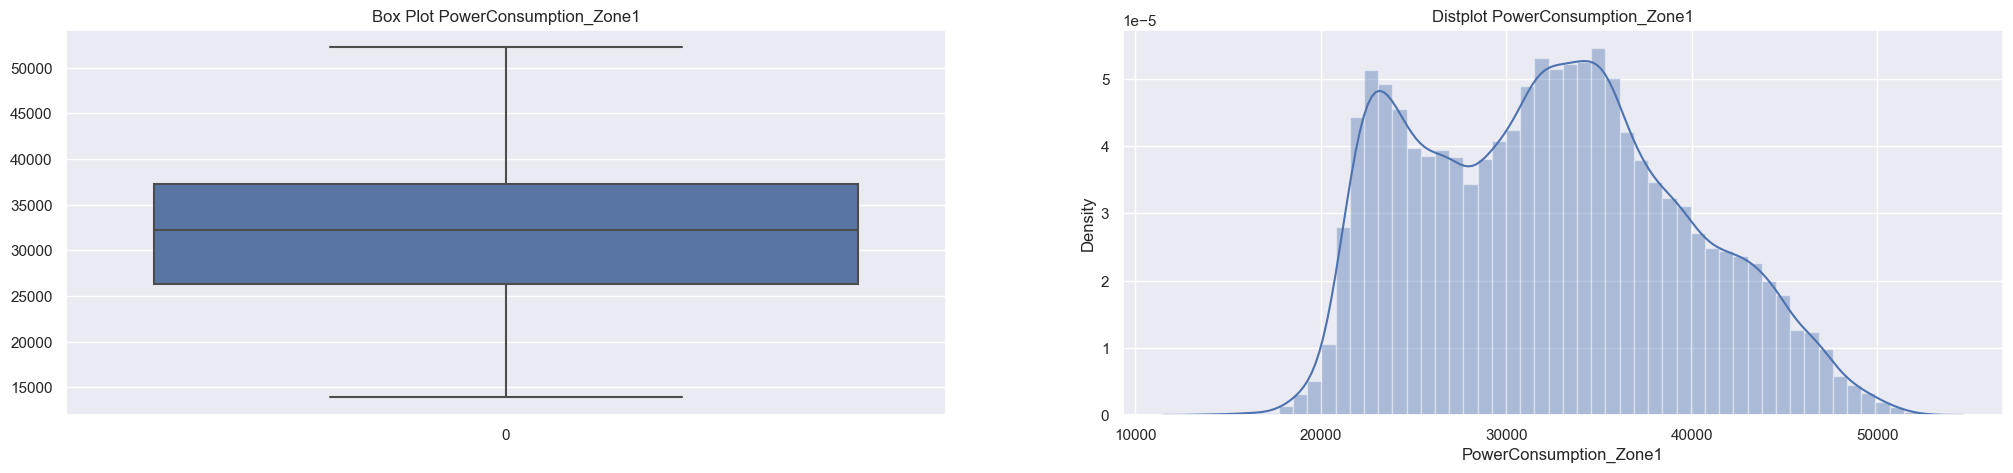

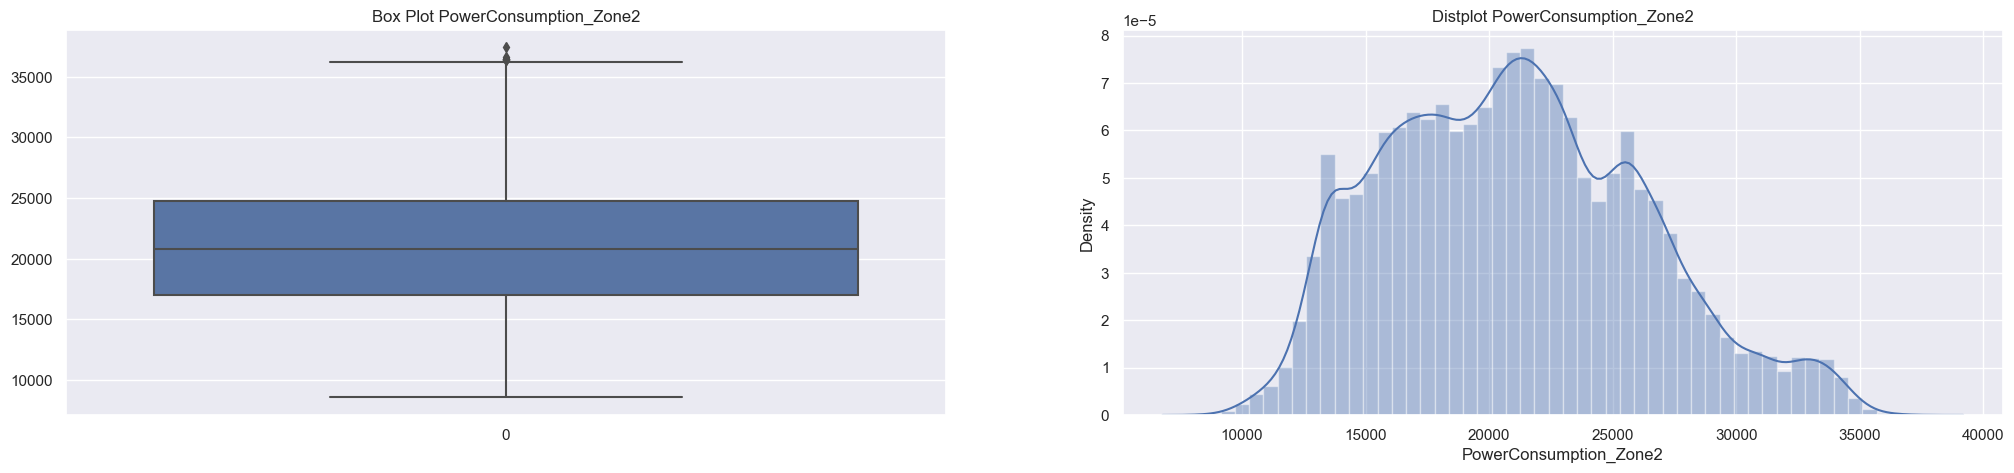

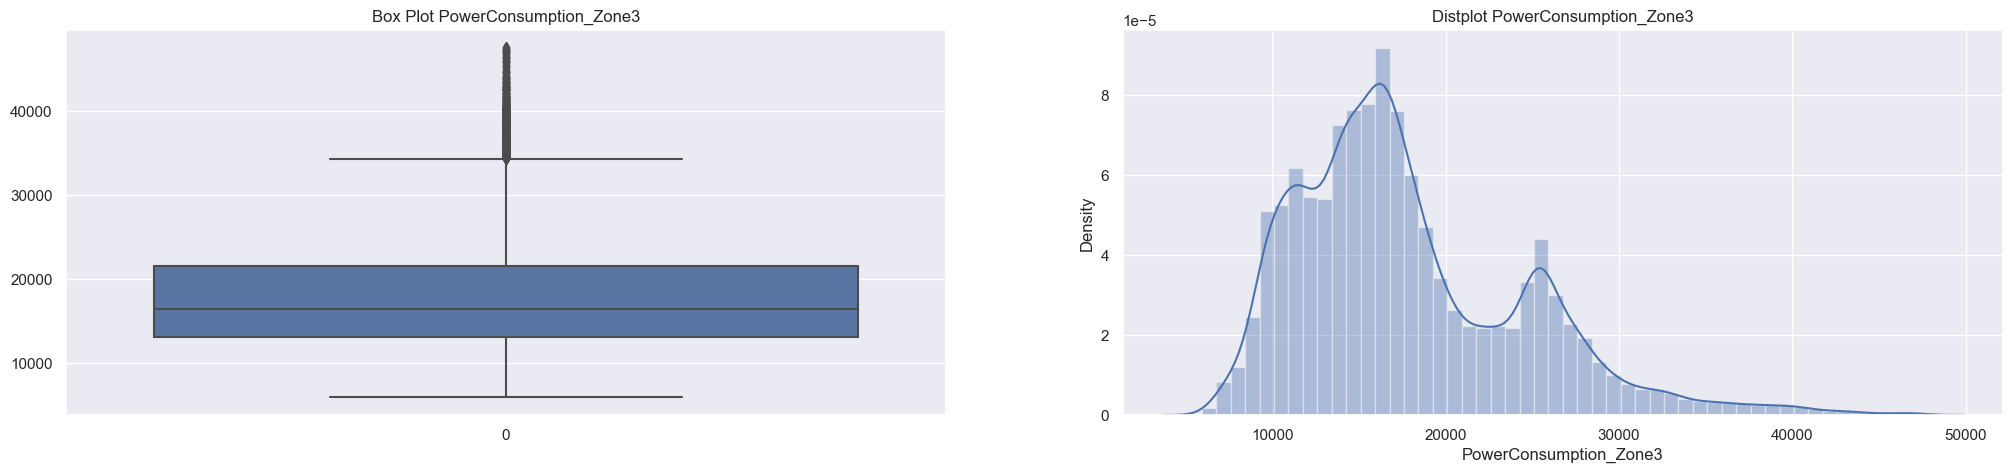

In [10]:
import warnings 
warnings.filterwarnings('ignore')

def out_li(datafram,col):
    sns.set(style='darkgrid')
    plt.figure(figsize=(25, 5))

    plt.subplot(1,2,1)
    sns.boxplot(datafram[col]).set(title='Box Plot {}'.format(col))
    plt.subplot(1,2,2)
    sns.distplot(datafram[col]).set(title='Distplot {}'.format(col))

    plt.show()

for i in numeric_columns:
    out_li(df,i)

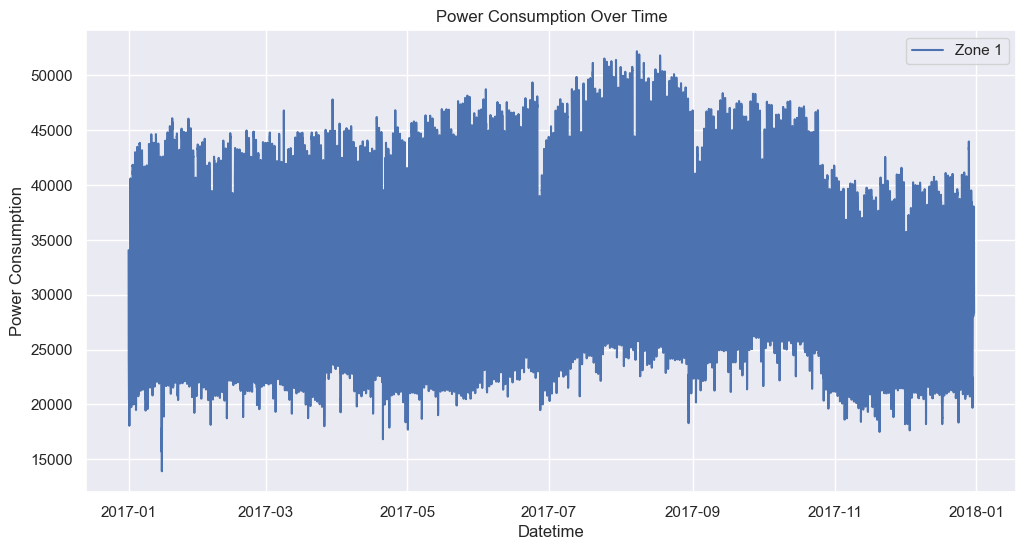

In [11]:
# Time series plot for PowerConsumption of Zone 1
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

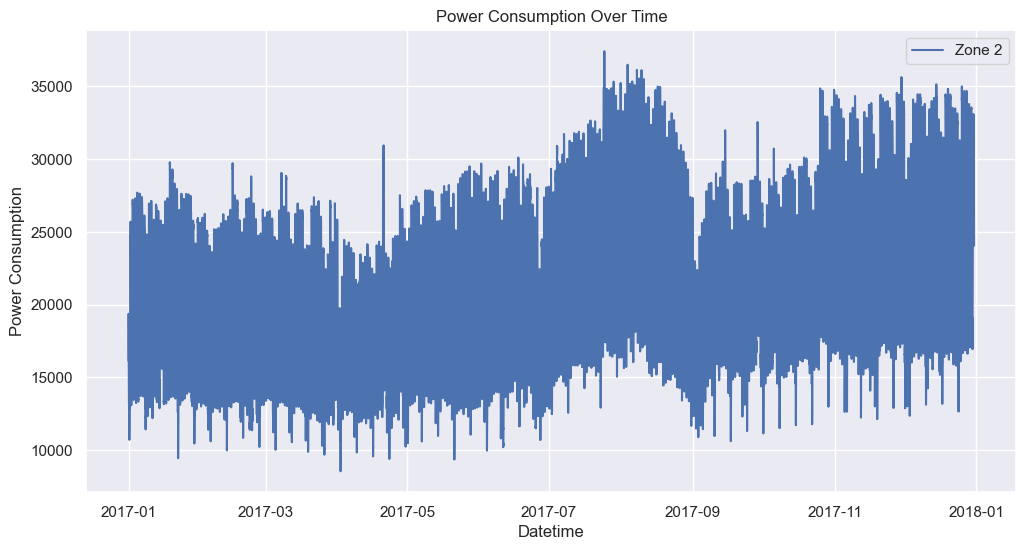

In [12]:
# Time series plot for PowerConsumption of Zone 2
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone2', data=df, label='Zone 2')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

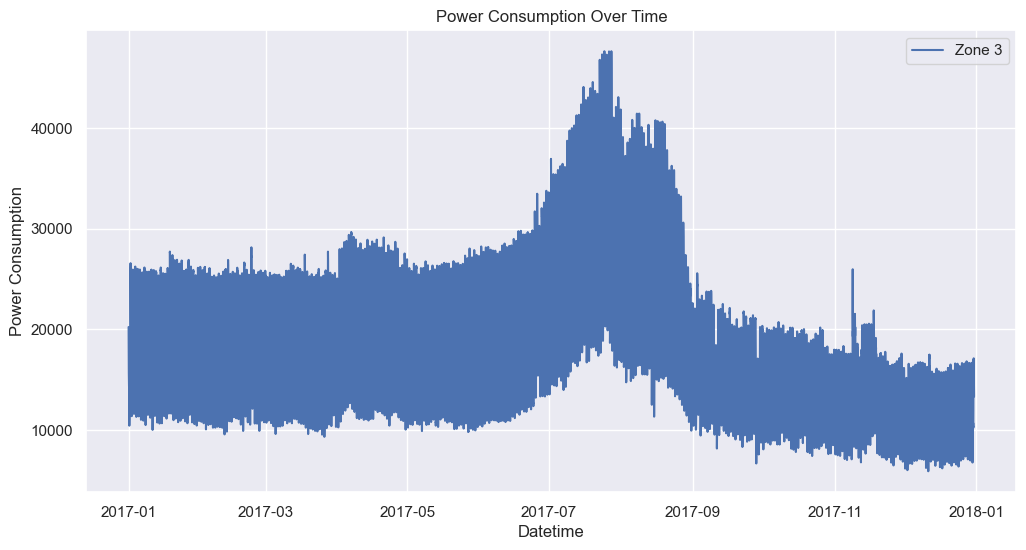

In [13]:
# Time series plot for PowerConsumption of Zone 3
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone3', data=df, label='Zone 3')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

In [14]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3', 'hour', 'minute', 'dayofweek', 'quarter',
       'month', 'day', 'year', 'season', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')

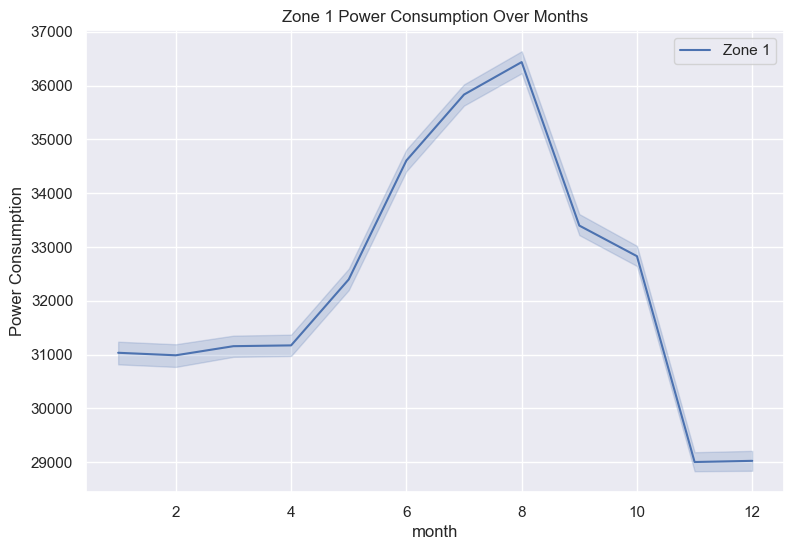

In [15]:
# Time series plot for PowerConsumption in months
plt.figure(figsize=(9, 6))
sns.lineplot(x='month', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('month')
plt.ylabel('Power Consumption')
plt.title('Zone 1 Power Consumption Over Months')
plt.show()

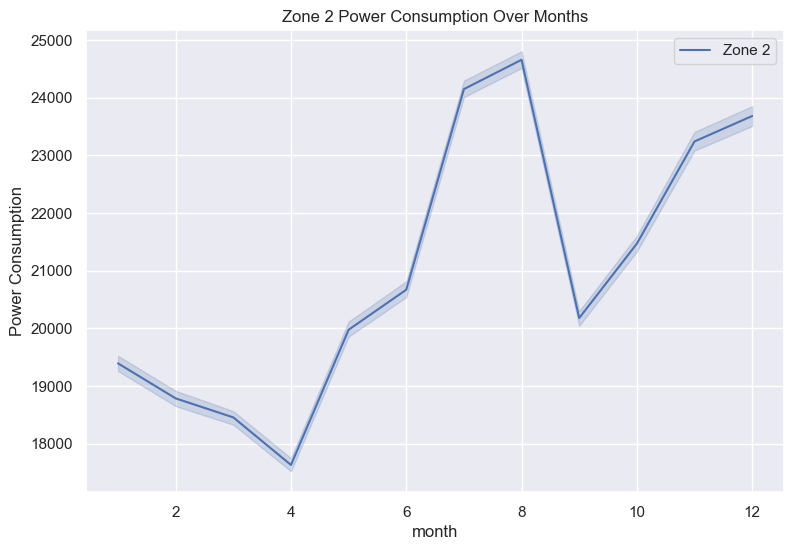

In [16]:
# Time series plot for PowerConsumption in months
plt.figure(figsize=(9, 6))
sns.lineplot(x='month', y='PowerConsumption_Zone2', data=df, label='Zone 2')
plt.xlabel('month')
plt.ylabel('Power Consumption')
plt.title('Zone 2 Power Consumption Over Months')
plt.show()

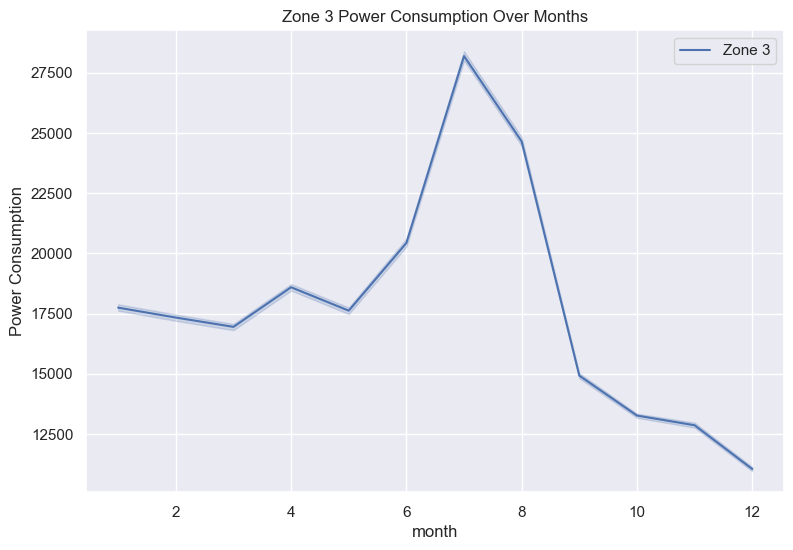

In [17]:
# Time series plot for PowerConsumption in months
plt.figure(figsize=(9, 6))
sns.lineplot(x='month', y='PowerConsumption_Zone3', data=df, label='Zone 3')
plt.xlabel('month')
plt.ylabel('Power Consumption')
plt.title('Zone 3 Power Consumption Over Months')
plt.show()

## 6. Exploratry Data Analysis

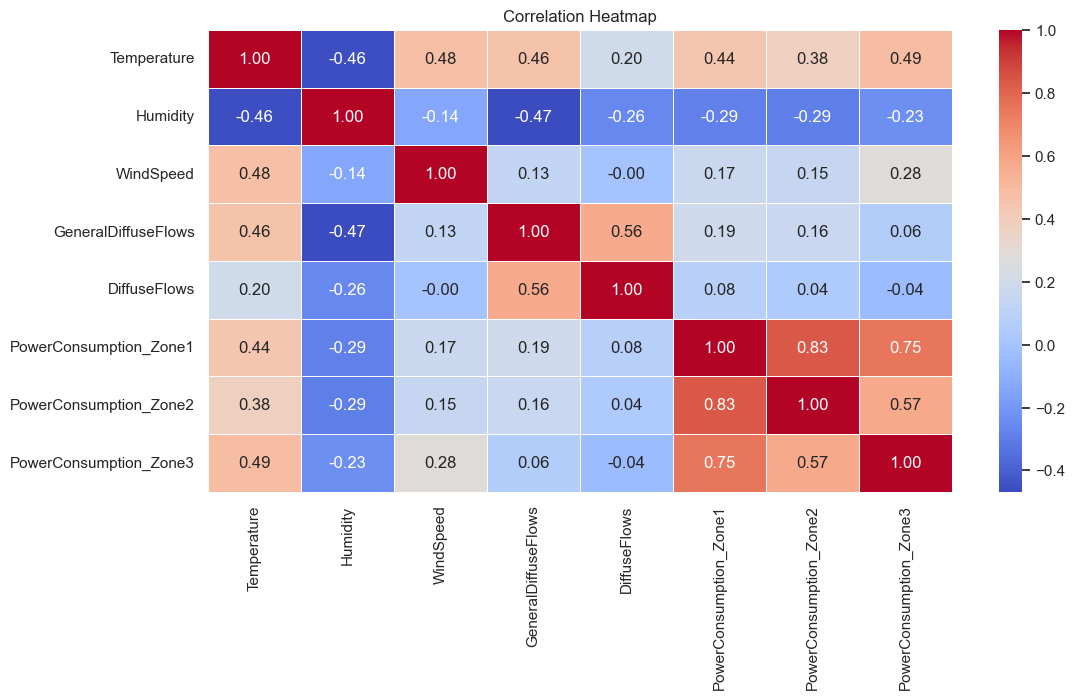

In [18]:
corr_mat = df[numeric_columns].corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_mat,annot=True,cmap='coolwarm',fmt='.2f',linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [19]:
# Resamplying the data for more meaning full time series analysis
daily_resampled = df.resample('D').mean()

In [20]:
daily_resampled

Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                             
2017-01-01     9.675299  68.519306   0.315146           121.390771   
2017-01-02    12.476875  71.456319   0.076563           120.404486   
2017-01-03    12.100000  74.981667   0.076715           120.686014   
2017-01-04    10.509479  75.459792   0.082417           122.959319   
2017-01-05    10.866444  71.040486   0.083896           118.749861   
...                 ...        ...        ...                  ...   
2017-12-26    11.621840  69.070903   0.083062           106.836687   
2017-12-27    15.232917  59.445903   0.082028            95.890674   
2017-12-28    13.662361  62.839375   0.081354           112.620160   
2017-12-29    12.990486  49.078750   0.078181           122.220021   
2017-12-30    11.688993  51.361667   0.078174           123.814125   

            DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
Datetime                                                                   
2017-01-01     25.993924            28465.232067            17737.791287   
2017-01-02     27.227410            28869.493671            19557.725431   
2017-01-03     28.574660            30562.447257            20057.269504   
2017-01-04     28.827222            30689.831224            20102.077001   
2017-01-05     29.741437            30802.911393            20033.941237   
...                  ...                     ...                     ...   
2017-12-26     50.760389            30013.476975            24757.006239   
2017-12-27     41.705062            29966.962399            25057.481845   
2017-12-28     30.209361            30267.004647            24585.251099   
2017-12-29     23.971021            29209.632446            24610.821315   
2017-12-30     24.039944            28145.669624            24211.286693   

            PowerConsumption_Zone3  hour  minute  dayofweek  quarter  month  \
Datetime                                                                      
2017-01-01            17868.795181  11.5    25.0        6.0      1.0    1.0   
2017-01-02            17820.763053  11.5    25.0        0.0      1.0    1.0   
2017-01-03            17620.803213  11.5    25.0        1.0      1.0    1.0   
2017-01-04            17673.694779  11.5    25.0        2.0      1.0    1.0   
2017-01-05            17664.176707  11.5    25.0        3.0      1.0    1.0   
...                            ...   ...     ...        ...      ...    ...   
2017-12-26            11395.678272  11.5    25.0        1.0      4.0   12.0   
2017-12-27            11498.279312  11.5    25.0        2.0      4.0   12.0   
2017-12-28            11167.026811  11.5    25.0        3.0      4.0   12.0   
2017-12-29            11171.268507  11.5    25.0        4.0      4.0   12.0   
2017-12-30            11560.824329  11.5    25.0        5.0      4.0   12.0   

             day    year  season  dayofyear  dayofmonth  weekofyear  
Datetime                                                             
2017-01-01   1.0  2017.0     1.0        1.0         1.0        52.0  
2017-01-02   1.0  2017.0     1.0        2.0         2.0         1.0  
2017-01-03   1.0  2017.0     1.0        3.0         3.0         1.0  
2017-01-04   1.0  2017.0     1.0        4.0         4.0         1.0  
2017-01-05   1.0  2017.0     1.0        5.0         5.0         1.0  
...          ...     ...     ...        ...         ...         ...  
2017-12-26  12.0  2017.0     1.0      360.0        26.0        52.0  
2017-12-27  12.0  2017.0     1.0      361.0        27.0        52.0  
2017-12-28  12.0  2017.0     1.0      362.0        28.0        52.0  
2017-12-29  12.0  2017.0     1.0      363.0        29.0        52.0  
2017-12-30  12.0  2017.0     1.0      364.0        30.0        52.0  

[364 rows x 19 columns]

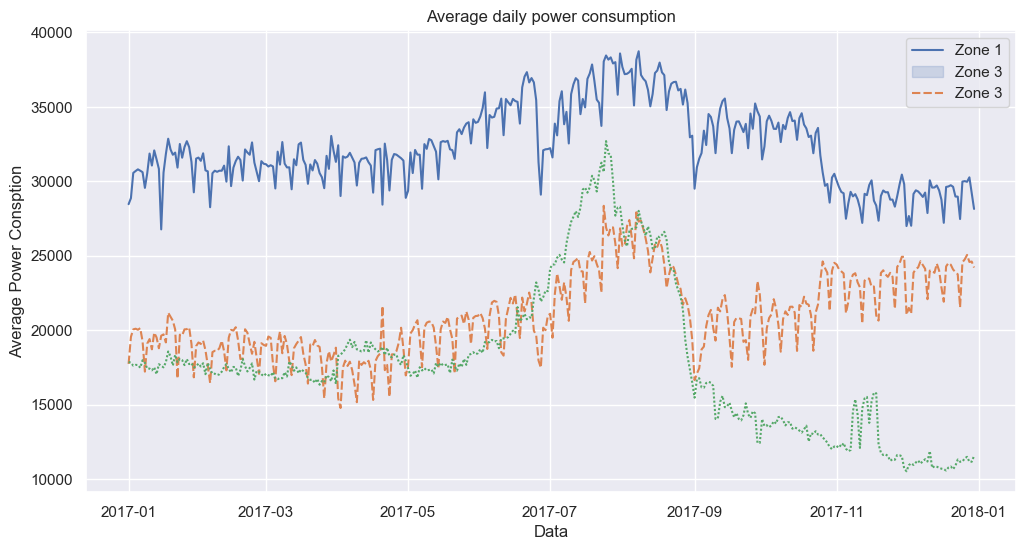

In [21]:
# lineplot of power cosumption
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3']])
plt.xlabel('Data')
plt.ylabel('Average Power Consption')
plt.title('Average daily power consumption')
plt.legend(labels=['Zone 1','Zone 3','Zone 3'])
plt.show()


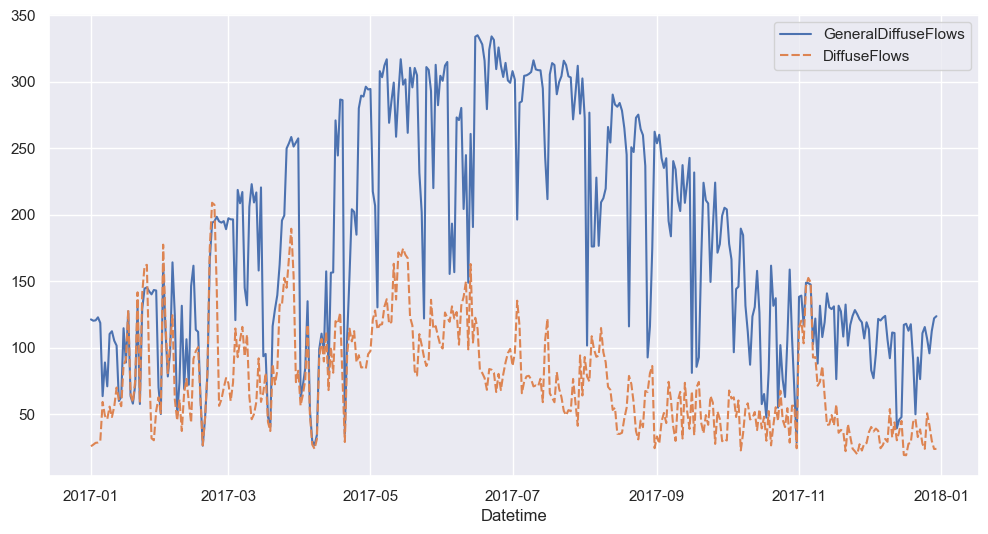

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_resampled[['GeneralDiffuseFlows','DiffuseFlows']])
plt.show()


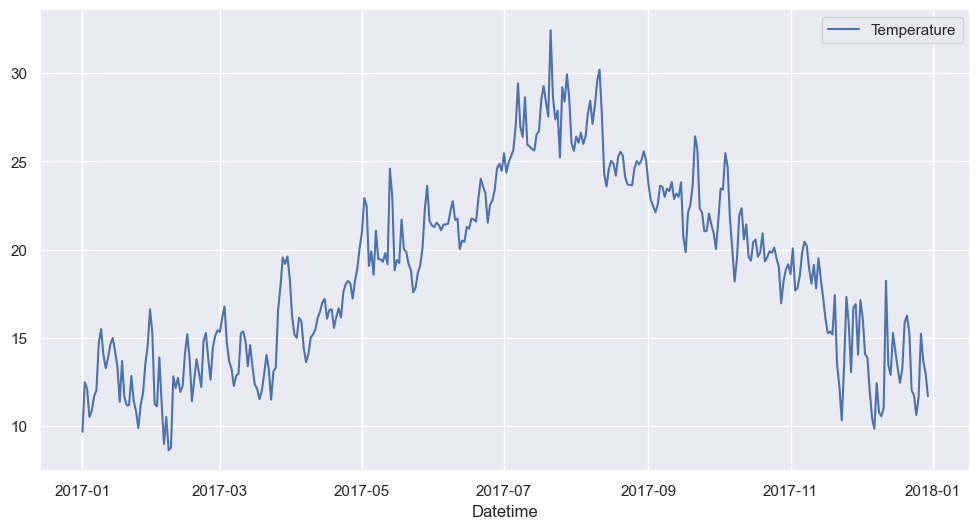

In [23]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_resampled[['Temperature']])
plt.show()

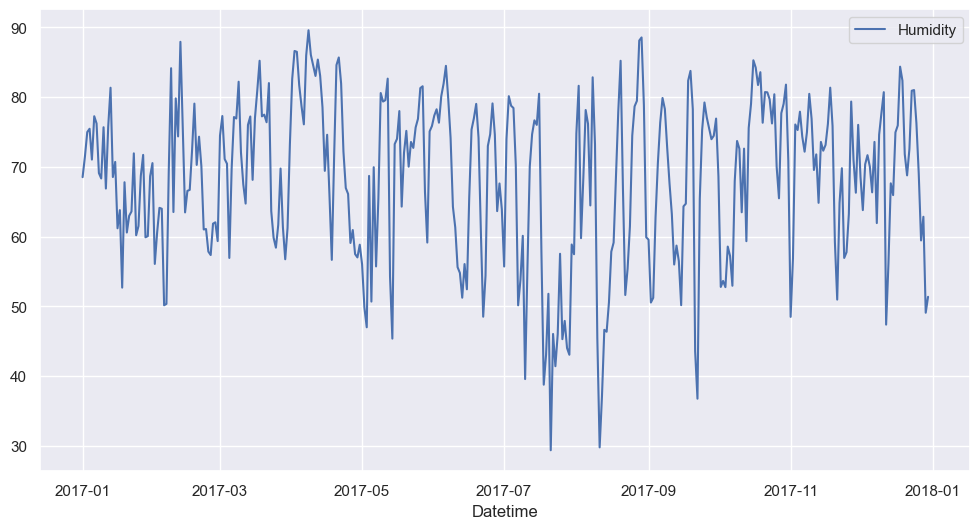

In [25]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_resampled[['Humidity']])
plt.show()

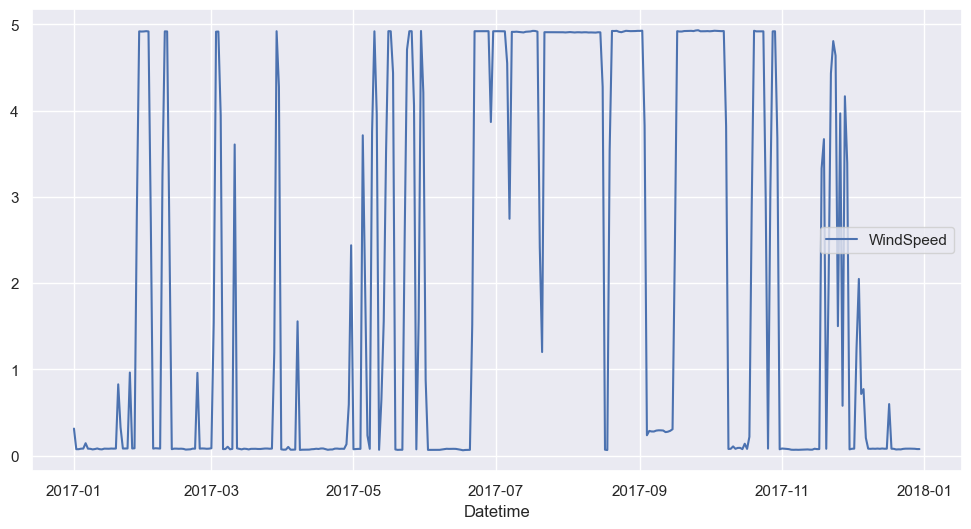

In [26]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_resampled[['WindSpeed']])
plt.show()

In [ ]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3', 'hour', 'minute', 'dayofweek', 'quarter',
       'month', 'day', 'year', 'season', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')

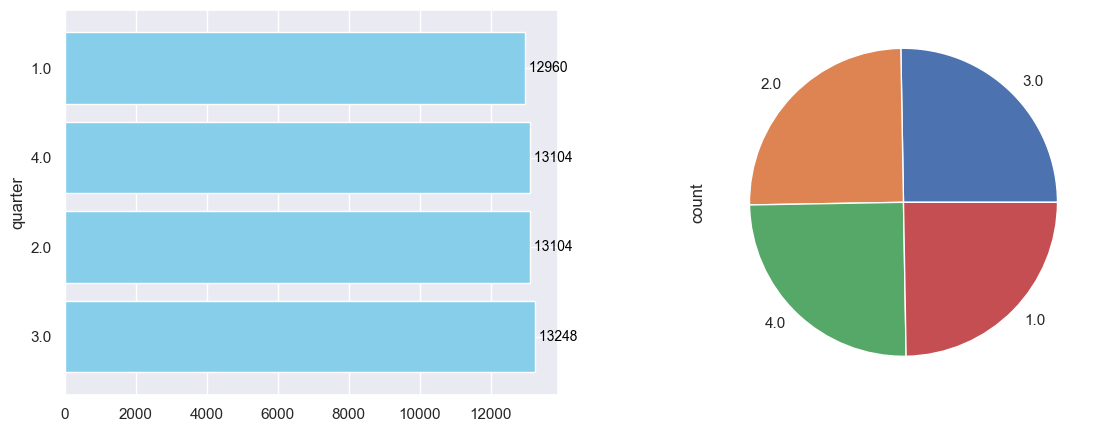

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=[14, 5])

qutor_counts = df['quarter'].value_counts()    
plt.subplot(1,2,1)
df['quarter'].value_counts().plot.barh(width=0.8, color='skyblue')
for index, value in enumerate(qutor_counts):
    plt.text(value, index, f' {value}', va='center', ha='left', color='black', fontsize=10)

plt.subplot(1,2,2)
df['quarter'].value_counts().plot.pie()

plt.show()

## 7. KPI's

In [33]:
df.head(5)

Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                     
2017-01-01 00:00:00        6.559      73.8      0.083                0.051   
2017-01-01 00:10:00        6.414      74.5      0.083                0.070   
2017-01-01 00:20:00        6.313      74.5      0.080                0.062   
2017-01-01 00:30:00        6.121      75.0      0.083                0.091   
2017-01-01 00:40:00        5.921      75.7      0.081                0.048   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 00:00:00         0.119             34055.69620   
2017-01-01 00:10:00         0.085             29814.68354   
2017-01-01 00:20:00         0.100             29128.10127   
2017-01-01 00:30:00         0.096             28228.86076   
2017-01-01 00:40:00         0.085             27335.69620   

                     PowerConsumption_Zone2  PowerConsumption_Zone3  hour  \
Datetime                                                                    
2017-01-01 00:00:00             16128.87538             20240.96386   0.0   
2017-01-01 00:10:00             19375.07599             20131.08434   0.0   
2017-01-01 00:20:00             19006.68693             19668.43373   0.0   
2017-01-01 00:30:00             18361.09422             18899.27711   0.0   
2017-01-01 00:40:00             17872.34043             18442.40964   0.0   

                     minute  dayofweek  quarter  month  day    year  season  \
Datetime                                                                      
2017-01-01 00:00:00     0.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:10:00    10.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:20:00    20.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:30:00    30.0        6.0      1.0    1.0  1.0  2017.0     1.0   
2017-01-01 00:40:00    40.0        6.0      1.0    1.0  1.0  2017.0     1.0   

                     dayofyear  dayofmonth  weekofyear  
Datetime                                                
2017-01-01 00:00:00        1.0         1.0        52.0  
2017-01-01 00:10:00        1.0         1.0        52.0  
2017-01-01 00:20:00        1.0         1.0        52.0  
2017-01-01 00:30:00        1.0         1.0        52.0  
2017-01-01 00:40:00        1.0         1.0        52.0

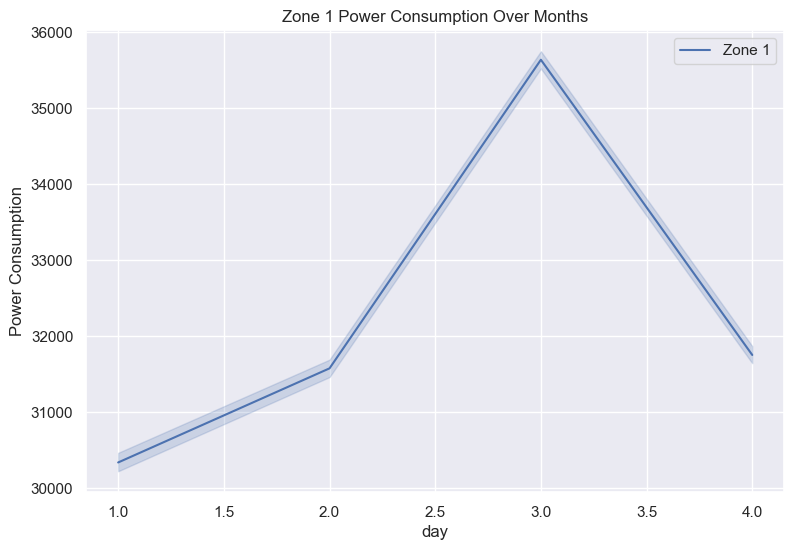

In [32]:
# Time series plot for PowerConsumption in months
plt.figure(figsize=(9, 6))
sns.lineplot(x='season', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('day')
plt.ylabel('Power Consumption')
plt.title('Zone 1 Power Consumption Over Months')
plt.show()